<a href="https://colab.research.google.com/github/juanferrgiraldo/big-data/blob/master/ICFES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Integrantes:
###Juan Fernando Giraldo Cardona
###Jose Fernando Gómez

##Instalación y configuración del ambiente

In [0]:
# instala el ambiente de spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
#Configura variables de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
#import  librerias a usar
import findspark
findspark.init()
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np

In [122]:
#monta el google drive para usar sus archivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# definir la sesion. Note que Inicia con pyspark
conf = SparkConf().setAppName("icfes").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [0]:
#inicia sesion en el cluster. Note que inicia con pyspark.sql
spark = SparkSession.builder.master("local[*]").getOrCreate()

##Variables globales

In [0]:
#base_url = '/content/drive/My Drive/Colab Notebooks/Taller Spark/SB'
base_url = '/content/drive/My Drive/Big Data/Taller Spark/SB'
files = [line.rstrip('\n') for line in open(f'{base_url}/{"files.txt"}')]
dff = ''
dff2 = ''
year = None
period = None

##Carga de los resultados por archivo

In [0]:
def load_file(file):
  return spark.read.load(f'{base_url}/{file}', format='csv', sep='¬', inferSchema='true', header='true')


#Ranking de colegios por año

##Depuración de las columnas que no serán usadas

In [0]:
def select_columns(df):
  global year, period
  year = str(df.select("periodo").head()[0])[0:4]
  period = str(df.select("periodo").head()[0])[4]

  for column in df.columns:
    df = df.withColumnRenamed(column, column.lower())   

  if "cole_cod_icfes" in df.columns:
    if df.select("periodo").head()[0] == 20061 or df.select("periodo").head()[0] == 20062:
      df = df.withColumnRenamed("punt_idioma", "punt_ingles")
    df = df.select("cole_cod_icfes", "cole_nombre_sede", "punt_lenguaje", "punt_matematicas", "punt_c_sociales", "punt_filosofia", "punt_biologia", "punt_quimica", "punt_fisica", "punt_ingles")

  elif ("cole_codigo_icfes" in df.columns) and ("punt_lectura_critica" in df.columns):
    if df.select("periodo").head()[0] == 20142:
      df = df.selectExpr("cole_codigo_icfes as cole_cod_icfes", "cole_nombre_establecimiento as cole_nombre_sede", "punt_lectura_critica", "punt_matematicas", "punt_c_naturales", "punt_sociales_ciudadanas", "punt_razona_cuantitativo", "punt_ingles")
    elif df.select("periodo").head()[0] == 20151 or df.select("periodo").head()[0] == 20152:
      df = df.selectExpr("cole_codigo_icfes as cole_cod_icfes", "cole_nombre_sede", "punt_lectura_critica", "punt_matematicas", "punt_c_naturales", "punt_sociales_ciudadanas", "punt_razona_cuantitativo", "punt_ingles")
    else:
      df = df.selectExpr("cole_codigo_icfes as cole_cod_icfes", "cole_nombre_sede", "punt_lectura_critica", "punt_matematicas", "punt_c_naturales", "punt_sociales_ciudadanas", "punt_ingles")
  else:
    df = df.selectExpr("cole_codigo_icfes as cole_cod_icfes", "cole_nombre_sede", "punt_matematicas", "punt_ciencias_sociales", "punt_biologia", "punt_lenguaje", "punt_filosofia", "punt_fisica", "punt_quimica", "punt_ingles")
  return df

## Cambios en el formato de la calificación

In [0]:
def change_format(df):
  for column in df.columns:
    if column != "cole_cod_icfes" and column != "cole_nombre_sede":
      df = df.withColumn(column, regexp_replace(column, ",", ".").cast("double"))
  return df

##Promedio por estudiante

In [0]:
def avg_est(df):
  sum_string = ""
  nro_columns = str(len(df.columns) - 1)

  for column in df.columns:
    if column != "cole_cod_icfes" and column != "cole_nombre_sede":
      sum_string = sum_string+ "+" + column
  return df.selectExpr("cole_cod_icfes" , "cole_nombre_sede", "(" + sum_string + ")/" + nro_columns + " as promedio_est" )

##Promedio por colegio

In [0]:
def avg_col(df):
  df = df.groupby("cole_cod_icfes", "cole_nombre_sede").avg("promedio_est").selectExpr("cole_cod_icfes", "cole_nombre_sede", "`avg(promedio_est)` as promedio_col")
  return df.orderBy(df["promedio_col"].desc())

##Graficar los 10 primeros colegios por año

In [0]:
def graph_ranking(df):
  global year
  top = 10
  width = 0.6
  schema = StructType([
    StructField("cole_code_icfes", StringType(), True),
    StructField("cole_nombre_sede", StringType(), True),
    StructField("promedio_col", DoubleType(), True),
])

  labels = df.select("cole_cod_icfes").head(top)
  labels = [str(label['cole_cod_icfes']) for label in labels]
  names = df.select("cole_nombre_sede").head(top)
  names = [name['cole_nombre_sede'] for name in names]
  values = df.select("promedio_col").head(top)
  values = [value['promedio_col'] for value in values]

  dfList = [[labels[row], names[row], values[row]] for row in range(top)]
  print('Ranking' + ' ' + year)
  spark.createDataFrame(dfList, schema).show()

  fig, ax = plt.subplots()
  ax.bar(labels, values, width)
  ax.set_xticklabels(labels)
  #ax.set_xticks(np.add(values, (width/2)))
  ax.set_xlabel('Código colegio')
  ax.set_ylabel('Promedio colegio')
  ax.set_title('Ranking' + ' ' + year)
  plt.show()

  

##Resultados

Ranking 2006
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          66845|INST ALBERTO MERA...| 58.48284722222222|
|          24059|LIC NAVARRA      ...|57.117283950617285|
|          23747|LIC  DE CERVANTES...|56.471412037037034|
|          12047|        COL CALASANZ| 56.25239651416122|
|          61614|COL  SAN BONIFACI...| 56.23802469135803|
|          99002|LIC CAMPO DAVID  ...| 55.78327485380116|
|          50039|ASPAEN GIMNASIO L...|55.738888888888894|
|         105171|CENT. DE ENSEÑANZ...|55.159333333333336|
|          25411|GIMN DE LOS CERRO...|55.123480083857444|
|          14472|COL EL ROSARIO   ...| 54.77692810457518|
+---------------+--------------------+------------------+



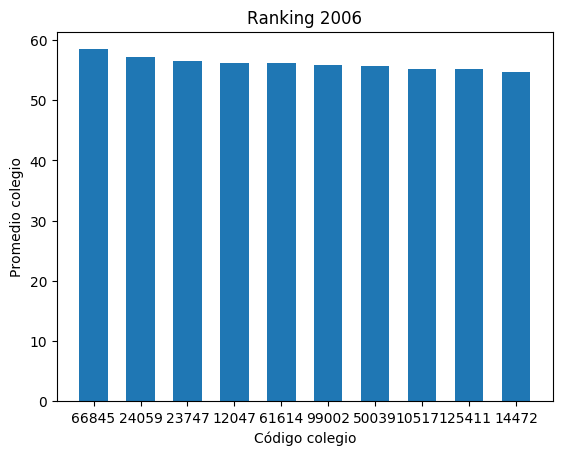

Ranking 2007
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          24059|LIC NAVARRA      ...| 57.23252525252526|
|          66845|INST ALBERTO MERA...| 56.82035087719298|
|          23747|LIC  DE CERVANTES...|56.576690561529276|
|          25338|COL REFOUS       ...| 55.96349794238683|
|          65177|ASPAEN GIMNASIO C...| 55.91903381642512|
|         105171|CENT. DE ENSEÑANZ...|55.757777777777775|
|          80127|COL CORAZONISTA H...| 55.44530239099858|
|          49189|COLEGIO SEMINARIO...| 55.37781893004115|
|          99002|LIC CAMPO DAVID  ...| 55.24805555555555|
|          61614|COL  SAN BONIFACI...| 54.99416666666667|
+---------------+--------------------+------------------+



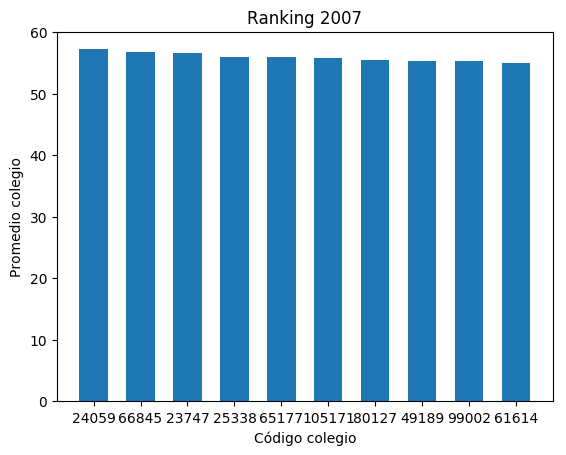

Ranking 2008
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          99002|LIC CAMPO DAVID  ...| 55.24076923076924|
|         138685|GLENN DOMAN ESCUE...| 54.88481481481481|
|          12047|        COL CALASANZ| 54.45906204906204|
|          24059|LIC NAVARRA      ...| 54.37498817966903|
|          65177|ASPAEN GIMNASIO C...|54.011830065359476|
|          23747|LIC  DE CERVANTES...| 53.81939814814816|
|         136267|COL REUVEN FEUERS...|53.641925925925925|
|          66845|INST ALBERTO MERA...| 53.62243055555555|
|           3194| NUEVO COL DEL PRADO| 53.31263888888889|
|          23895|LIC JUAN RAMON JI...| 53.20338383838384|
+---------------+--------------------+------------------+



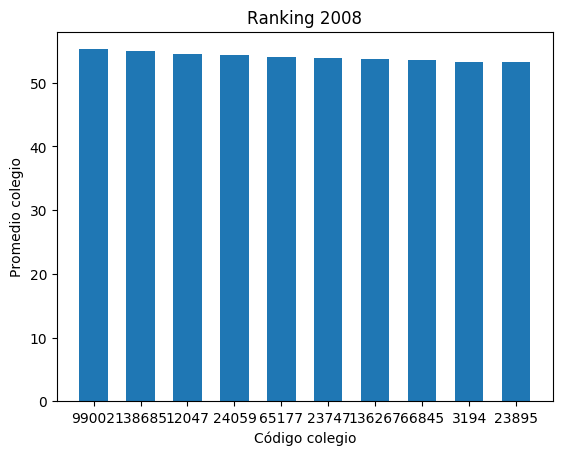

Ranking 2009
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          99002|LIC CAMPO DAVID  ...|55.361180555555556|
|          49189|COLEGIO SEMINARIO...| 55.22283333333333|
|          66845|INST ALBERTO MERA...| 54.86730994152047|
|          14233|COL  SAN PEDRO CL...|54.758180924287124|
|          25338|COL REFOUS       ...|54.500086580086574|
|          14472|COL EL ROSARIO   ...| 54.28373983739837|
|          65177|ASPAEN GIMNASIO C...|  54.2818888888889|
|          79806|COL NUEVO COLOMBO...| 53.89460992907802|
|          23747|LIC  DE CERVANTES...| 53.84097365406642|
|          80127|COL CORAZONISTA H...| 53.76341111111111|
+---------------+--------------------+------------------+



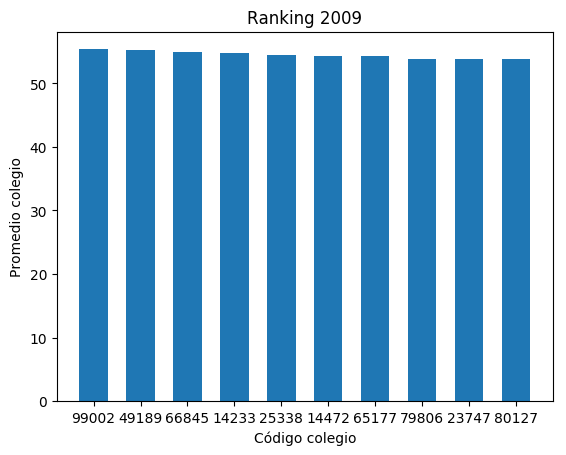

Ranking 2010
+---------------+--------------------+-----------------+
|cole_code_icfes|    cole_nombre_sede|     promedio_col|
+---------------+--------------------+-----------------+
|          99002|LIC CAMPO DAVID  ...|69.36392592592593|
|          66845|INST ALBERTO MERA...|68.94339506172838|
|          59337|INST MUSICAL DIEG...|            67.94|
|          98640|GIMNASIO COLOMBO ...|67.23111111111108|
|          19810|COL ANGLO AMERICA...|66.09880597014926|
|           3665|FUND EDUC. INST E...|65.59338624338625|
|          61614|COL  SAN BONIFACI...| 65.5642328042328|
|          65177|ASPAEN GIMNASIO C...|65.48888888888891|
|          14233|COL  SAN PEDRO CL...|65.28145438121045|
|          80127|COL CORAZONISTA H...|64.65999066293183|
+---------------+--------------------+-----------------+



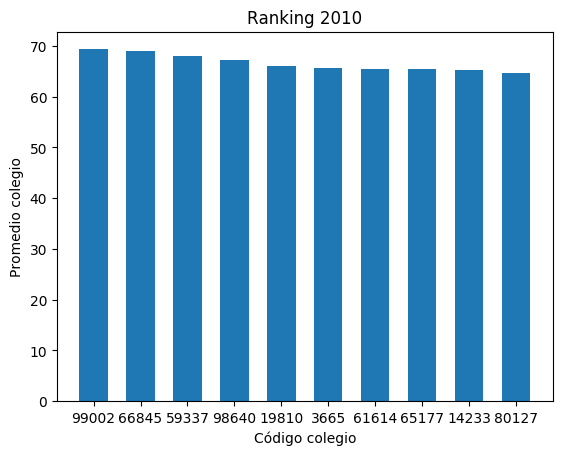

Ranking 2011
+---------------+--------------------+-----------------+
|cole_code_icfes|    cole_nombre_sede|     promedio_col|
+---------------+--------------------+-----------------+
|          98640|GIMNASIO COLOMBO ...|60.39878234398781|
|          80127| COLEGIO CORAZONISTA|58.02626262626262|
|          68817|BILIGUE INTERNACI...|             58.0|
|         138685|GLENN DOMAN ESCUE...|57.81481481481482|
|           3665|FUNDACION EDUCATI...|57.73737373737372|
|          19810|COL ANGLO AMERICA...|57.20209339774557|
|          65177|ASPAEN GIMNASIO C...|57.00952380952382|
|          99002|LIC CAMPO DAVID  ...|56.81481481481482|
|          14472|COL EL ROSARIO   ...|56.77430555555555|
|            190|COL DE LA COMPANI...|56.50682261208576|
+---------------+--------------------+-----------------+



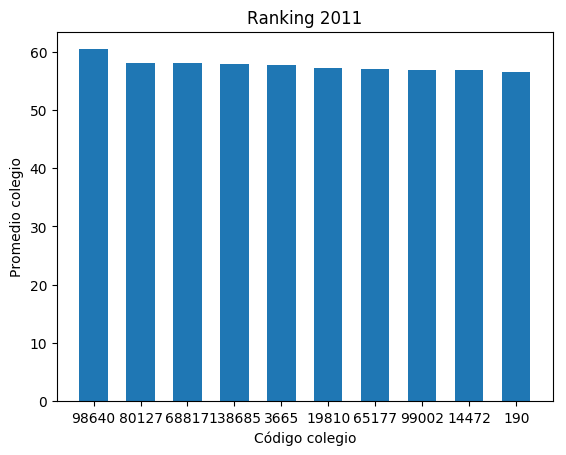

Ranking 2012
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|           None|COL  SAN PEDRO CL...| 63.55555555555556|
|          90928|COL NUEVO COLOMBO...| 60.44444444444444|
|           None|COL BILING DE LA ...| 60.22222222222222|
|         125211|CAMBRIDGE SCHOOL ...| 60.19607843137254|
|          99002|     LIC CAMPO DAVID| 59.60233918128656|
|          98640|GIMNASIO COLOMBO ...| 59.19999999999999|
|          66845| INST ALBERTO MERANI| 59.09523809523809|
|         153254|I.E.M. SAN JUAN B...|58.666666666666664|
|          96578| COLEGIO LOS ÁNGELES| 58.53418803418803|
|           None|TANDEM - SEDE PRI...|58.333333333333336|
+---------------+--------------------+------------------+



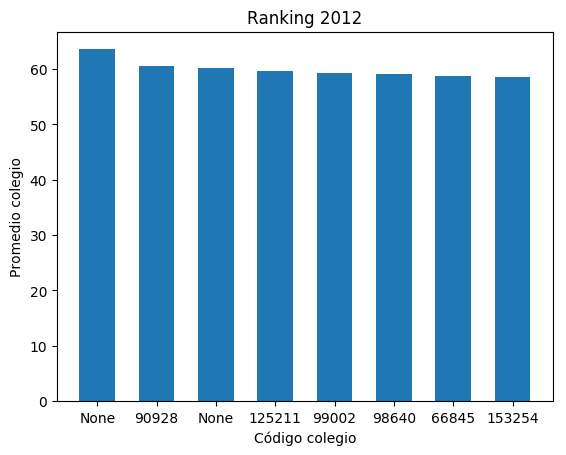

Ranking 2013
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          66845| INST ALBERTO MERANI| 62.59477124183007|
|          98640|GIMNASIO COLOMBO ...| 61.91887125220458|
|          17228|COLEGIO PARROQIAL...| 61.22222222222222|
|          19448|   COL NUEVA GRANADA|60.666666666666664|
|         125211|CAMBRIDGE SCHOOL ...| 60.59259259259259|
|          99002|     LIC CAMPO DAVID|60.583333333333336|
|         130245|   COL SAINT ANDREWS| 60.46296296296297|
|          80127| COLEGIO CORAZONISTA|60.396057347670244|
|           3665|FUNDACION EDUCATI...|60.351851851851855|
|          79806|COL NUEVO COLOMBO...|60.277777777777786|
+---------------+--------------------+------------------+



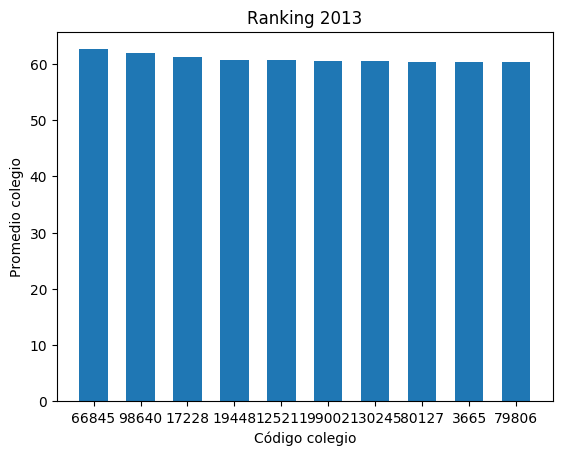

Ranking 2014
+---------------+--------------------+-----------------+
|cole_code_icfes|    cole_nombre_sede|     promedio_col|
+---------------+--------------------+-----------------+
|          98640|COLOMBO BRITANICO...|67.56944444444443|
|         125211|CAMBRIDGE SCHOOL ...|67.20408163265306|
|          24059|         LIC NAVARRA|66.23492063492063|
|          66845| INST ALBERTO MERANI|65.74553571428571|
|          79806|COL NUEVO COLOMBO...|65.57802197802198|
|          99002|     LIC CAMPO DAVID|65.57142857142857|
|          25338|          COL REFOUS|65.21825396825396|
|          19810| COL ANGLO AMERICANO|65.19965576592082|
|          80127| COLEGIO CORAZONISTA|64.73058485139023|
|          14472|      COL EL ROSARIO| 64.0748299319728|
+---------------+--------------------+-----------------+



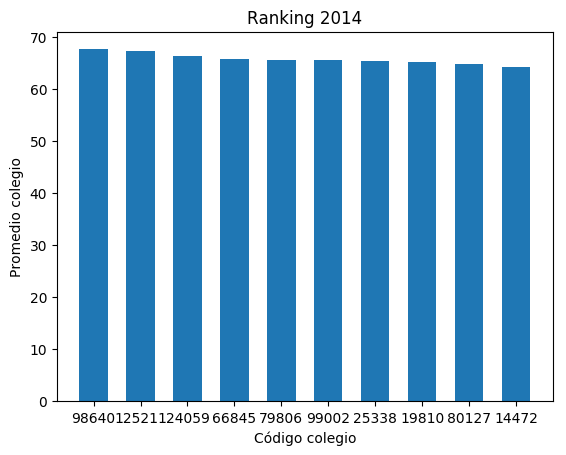

Ranking 2015
+---------------+--------------------+-----------------+
|cole_code_icfes|    cole_nombre_sede|     promedio_col|
+---------------+--------------------+-----------------+
|          99002|     LIC CAMPO DAVID|            72.75|
|          79806|COL NUEVO COLOMBO...|70.69565217391305|
|          24059|         LIC NAVARRA|70.00000000000001|
|          66845| INST ALBERTO MERANI| 69.3896103896104|
|         125211|CAMBRIDGE SCHOOL ...|69.14285714285714|
|          19810| COL ANGLO AMERICANO|69.03101503759399|
|          75176|        COL EL PINAR|68.42857142857143|
|          98640|NUEVO GIMN COLOMB...|68.16817359855335|
|           3194| NUEVO COL DEL PRADO|67.80952380952381|
|          66431|COL INTERNACIONAL...|67.57142857142857|
+---------------+--------------------+-----------------+



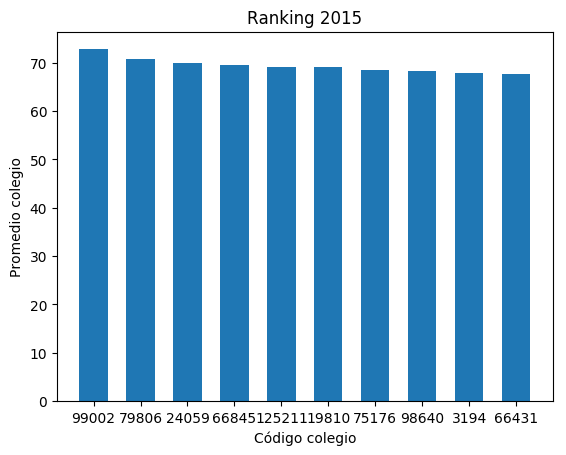

Ranking 2016
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          99002|     LIC CAMPO DAVID| 64.69444444444444|
|          79806|COL NUEVO COLOMBO...| 64.28070175438597|
|          63438|COL NUEVA INGLATERRA| 63.78086419753086|
|           3194| NUEVO COL DEL PRADO|63.688034188034194|
|          98640|NUEVO GIMN COLOMB...|63.504385964912274|
|          19810| COL ANGLO AMERICANO| 63.50141242937855|
|          24059|         LIC NAVARRA| 63.30081300813007|
|         128728|GIMN EL HONTANAR ...|             63.15|
|          66845| INST ALBERTO MERANI|              62.8|
|          61614|COL  SAN BONIFACI...|             62.75|
+---------------+--------------------+------------------+



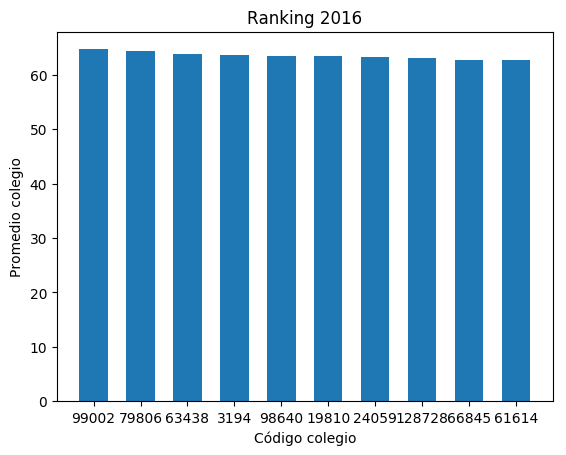

Ranking 2017
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          99002|     LIC CAMPO DAVID|63.950980392156865|
|          98640|GIMNASIO COLOMBO ...|63.704402515723274|
|         128728|GIMNASIO EL HONTA...| 63.50000000000001|
|          19810| COL ANGLO AMERICANO| 63.34523809523809|
|          79806|COL NUEVO COLOMBO...| 63.30327868852459|
|           3194| NUEVO COL DEL PRADO| 63.19696969696971|
|          24059|         LIC NAVARRA|62.962962962962955|
|          61614|COL  SAN BONIFACI...| 62.76041666666668|
|          66845| INST ALBERTO MERANI|62.540650406504064|
|         147173|COL  ANGLOCANADIE...|62.431818181818194|
+---------------+--------------------+------------------+



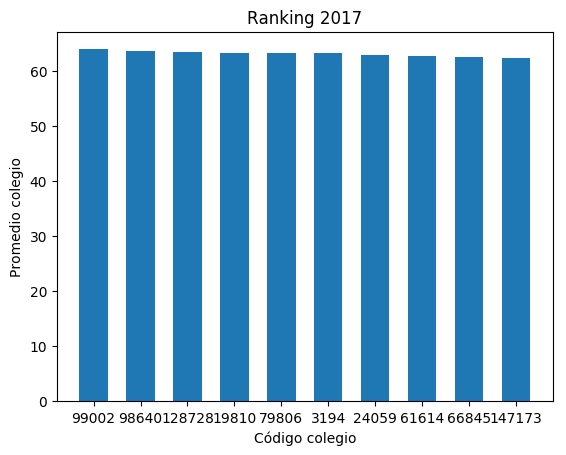

Ranking 2018
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|         150615|COL HERALDOS DEL ...|              66.5|
|          99002|     LIC CAMPO DAVID| 65.16666666666667|
|         125211|CAMBRIDGE SCHOOL ...| 64.46666666666667|
|          79806|COL NUEVO COLOMBO...| 63.95833333333334|
|          66845| INST ALBERTO MERANI| 63.91666666666666|
|          98640|GIMNASIO COLOMBO ...| 63.88308457711443|
|          19810| COL ANGLO AMERICANO| 63.38268156424581|
|          65177|ASPAEN GIMNASIO C...| 63.33333333333333|
|          24059|         LIC NAVARRA|63.131944444444436|
|         118539|          COL INGLES| 63.05882352941177|
+---------------+--------------------+------------------+



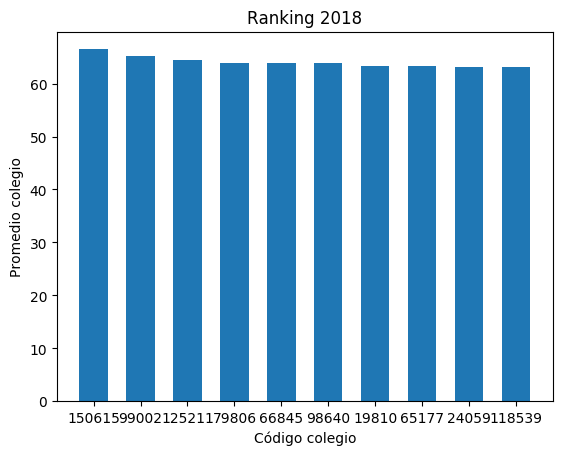

Ranking 2019
+---------------+--------------------+------------------+
|cole_code_icfes|    cole_nombre_sede|      promedio_col|
+---------------+--------------------+------------------+
|          79160|COLEGIO BILINGUE ...| 67.27083333333333|
|         110858| COL NUEVO CAMBRIDGE| 66.78104575163401|
|          55129|COL LA QUINTA DEL...|             66.25|
|          19471|COL SAN CARLOS   ...|63.676136363636395|
|          24281|COL SAN JORGE DE ...|63.643192488262926|
|          55988|     COL LOS NOGALES| 63.41818181818181|
|         177469|COL  MONTESSORI B...| 62.98571428571427|
|          43562|COL CAMPOALEGRE L...|62.614035087719316|
|          62497|COL SAN MATEO APO...| 62.57954545454543|
|         111658|COL CALATRAVA - S...| 62.56666666666668|
+---------------+--------------------+------------------+



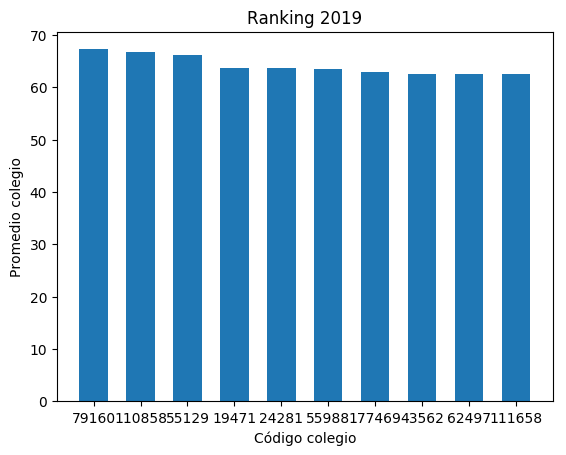

In [259]:
def cole_rank():
  global period
  global year
  global base_url
  global dff
  files = [line.rstrip('\n') for line in open(f'{base_url}/{"files.txt"}')]

  schema = StructType([
      StructField("cole_code_icfes", IntegerType(), True),
      StructField("cole_nombre_sede", StringType(), True),
      StructField("promedio_col", DoubleType(), True),
  ])
      
  dff = spark.createDataFrame([], schema)
  period = '0'
  for file in files:
    dff = avg_est(change_format(select_columns(load_file(file))))
    if period == '2':
      dff = dff.union(dff)
      dff = graph_ranking(avg_col(dff))
    if year == '2019':
      dff = graph_ranking(avg_col(dff))

      
    #dff = dff.union(avg_col(avg_est(change_format(select_columns(load_file(file))))))
cole_rank()

#Número de estudiantes por año

##Depuración de la columnas que no serás usadas

In [0]:
def get_columns(df):
  global year, period
  year = str(df.select("periodo").head()[0])[0:4]
  period = str(df.select("periodo").head()[0])[4]

  for column in df.columns:
    df = df.withColumnRenamed(column, column.lower())

    if "cole_cod_icfes" in df.columns:
      df = df.select("cole_cod_icfes", "periodo", "estu_estudiante")

    if "cole_codigo_icfes" in df.columns:
      df = df.selectExpr("cole_codigo_icfes as cole_cod_icfes", "periodo", "estu_estudiante")
  return df

##Contar estudiantes

In [0]:
def count_stu(df):
  #student, individual = 0
  global year
  schema = StructType([
      StructField("año", StringType(), True),
      StructField("estudiante", IntegerType(), True),
      StructField("individual", IntegerType(), True),
  ])
  
  if df.select("periodo").head()[0] <= 20111:   
    individual = df.select("cole_cod_icfes", "estu_estudiante", ).filter(df.estu_estudiante == 1).count()
    student = df.select("cole_cod_icfes", "estu_estudiante", ).filter(df.estu_estudiante == 0).count()
  else:
    student = df.select("cole_cod_icfes", "estu_estudiante", ).filter(df.estu_estudiante == 'ESTUDIANTE').count()
    individual = df.select("cole_cod_icfes", "estu_estudiante", ).filter(df.estu_estudiante == "INDIVIDUAL").count()

  data = [(year, student, individual)]
  return spark.createDataFrame(data, schema)

##Resultados

In [333]:
def student_year():
  global period, year, files, dff2
  schema = StructType([
      StructField("year", StringType(), True),
      StructField("estudiante", IntegerType(), True),
      StructField("individual", IntegerType(), True),
  ])

  df = dff = spark.createDataFrame([], schema)
  
  for file in files:
    df = df.union(count_stu(get_columns(load_file(file))))

  dff2 = df.groupBy("year").agg(sum("estudiante"), sum("individual")).selectExpr("year", "`sum(estudiante)` as estudiente", "`sum(individual)` as individual")
  dff2.orderBy(df["year"]).show()

student_year()

+----+----------+----------+
|year|estudiente|individual|
+----+----------+----------+
|2006|         0|    471878|
|2007|         0|    502389|
|2008|         0|    506431|
|2009|         0|    524811|
|2010|         0|    570844|
|2011|    540707|     31712|
|2012|    580551|         0|
|2013|    576092|         0|
|2014|    569294|         0|
|2015|    568397|         0|
|2016|    561271|         0|
|2017|    559155|         0|
|2018|    569732|         0|
|2019|     21083|         0|
+----+----------+----------+

